In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [2]:
from bliss import sleep
from bliss.datasets import simulated

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# load data

In [5]:
from astropy.io import fits
hdul = fits.open('./data/decaps_l0_b0_hdu08_z')

image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

In [6]:
image.min()

tensor(15.0047)

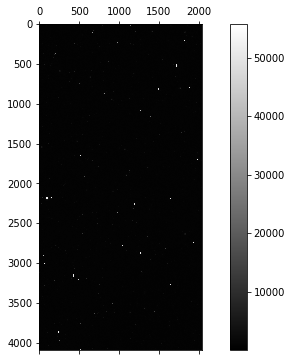

In [7]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

In [8]:
# f, ax = plt.subplots(1, 1, figsize=(10, 6))

# im = plotting.plot_image(ax, image[0, 0, 50:100, 0:50])

# f.colorbar(im, ax = ax)

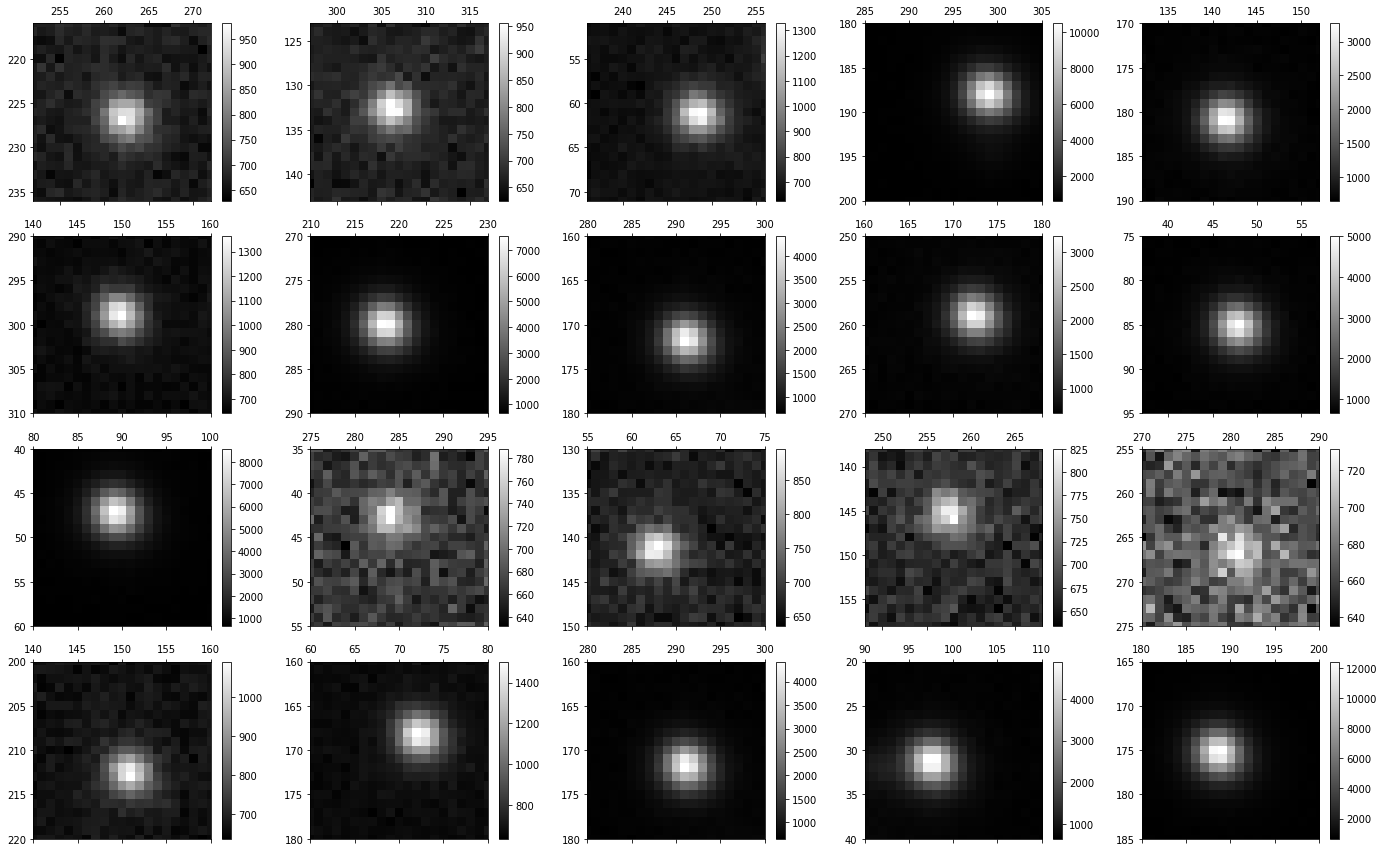

In [9]:
f, axarr = plt.subplots(4, 5, figsize=(24, 15))

subimage_slen = 20
# x0_vec = np.arange(x0, x0 + slen, subimage_slen)
# x1_vec = np.arange(x1, x1 + slen, subimage_slen)

x0_vec = [216, 123, 51, 180, 170, 290, 270, 160, 250, 75, 40, 35, 130, 138, 255, 200, 160, 160, 20, 165]
x1_vec = [252, 297, 236, 285, 132, 140, 210, 280, 160, 37, 80, 275, 55, 248, 270, 140, 60, 280, 90, 180]

# x0_vec = [216, 123, 51, 170, 290, 35, 130, 138, 200, 160, 32, 54, 40, 20]
# x1_vec = [252, 297, 236, 132, 140, 275, 55, 248, 140, 60, 275, 157, 50, 195]

# x0_vec = [37, 165, 2, 75, 171]
# x1_vec = [80, 179, 298, 38, 131]

# x0_vec = [138, 35]
# x1_vec = [248, 275]


for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    ax = axarr[i // 5,  i % 5]
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

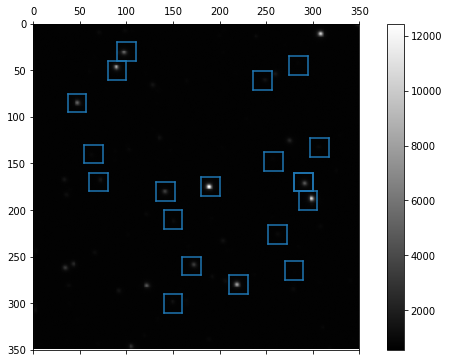

In [10]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

tmp = image[0, 0, 0:350, 0:350]
im = plotting.plot_image(ax, tmp)

f.colorbar(im, ax = ax)

for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    ax.axvline(_x1, 
               ymin = (tmp.shape[1] - _x0) / tmp.shape[1], 
               ymax = (tmp.shape[1] - _x0 - subimage_slen) / tmp.shape[1])
    ax.axvline(_x1 + subimage_slen, 
               ymin = (tmp.shape[1] - _x0) / tmp.shape[1], 
               ymax = (tmp.shape[1] - _x0 - subimage_slen) / tmp.shape[1])

    ax.axhline(_x0, 
               xmin = _x1 / tmp.shape[0], 
               xmax = (_x1 + subimage_slen) / tmp.shape[1])
    ax.axhline(_x0 + subimage_slen, 
               xmin = _x1 / tmp.shape[0], 
               xmax = (_x1 + subimage_slen) / tmp.shape[1])

In [11]:
psf_train_images = torch.zeros(len(x0_vec), 
                              image.shape[1],
                              subimage_slen, 
                              subimage_slen)

for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    psf_train_images[i] = image[0, :, _x0:(_x0+subimage_slen), _x1:(_x1+subimage_slen)]

In [12]:
from torch import nn
from torch import optim
from torch.distributions import Normal

from bliss.models import decoder

In [13]:
class CatalogParams(nn.Module):
    def __init__(self, n_bands = 1, n_images = 10): 
        
        super(CatalogParams, self).__init__()
                
        self.n_bands = n_bands
        self.n_images = n_images
        
        logit_locs = torch.zeros((n_images, 1, 2))
        log_fluxes = torch.zeros((n_images, 1, n_bands)) + np.log(1000)
        log_back = torch.Tensor([np.log(670.)])
        
        
        self.logit_loc_params = nn.Parameter(logit_locs.clone(), requires_grad=True)
        self.log_flux_params = nn.Parameter(log_fluxes.clone(), requires_grad=True)
        self.log_back_params = nn.Parameter(log_back.clone(), requires_grad=True)
        
    def forward(self): 
        
        locs = torch.sigmoid(self.logit_loc_params)
        fluxes = torch.exp(self.log_flux_params)
        sky_back = torch.exp(self.log_back_params)
        
        # sky_back = 665.
        
        return locs, fluxes, sky_back

In [14]:
tile_slen = 20
n_bands = 1
psf_slen = 51
# psf_params_file = './psf/zband_psf_gauss.npy'
psf_params_file = './psf/zband_psf_init.npy'
# psf_params_file = './psf/testing.npy'

tiler = decoder.Tiler(tile_slen, tile_slen)

star_decoder = decoder.StarTileDecoder(tiler, 
                                       n_bands = n_bands, 
                                       psf_slen = psf_slen, 
                                       psf_params_file = psf_params_file)


In [15]:
# foo = star_decoder.params.detach()
# foo[0, 0] = 0.5
# np.save('./psf/testing.npy', 
#         foo.numpy())

In [16]:
catalog_params = CatalogParams(n_images=psf_train_images.shape[0])

In [17]:
def get_loss(images,
             catalog_params,
             star_decoder,
             sky_back = 670, 
             detach_psf = True): 
    
    # get catalog
    locs, fluxes, sky_back = catalog_params()
    star_bool = torch.ones((images.shape[0], 1, 1))
    
    # get reconstruction
    recon_mean = star_decoder.forward(locs, fluxes, star_bool, detach_psf) + sky_back

    normal = Normal(loc=recon_mean, scale=torch.sqrt(recon_mean))

    return -normal.log_prob(images).mean(), recon_mean


In [18]:
def run_lbfgs(images,
              optim_parameters,
              catalog_params, 
              star_decoder,
              detach_psf, 
              lr = 1, 
              max_outer_iter=10, 
              max_inner_iter=50,
              tol=1e-8,
              print_every=True): 
    
    optimizer = optim.LBFGS(
        optim_parameters,
        max_iter=max_inner_iter,
        line_search_fn="strong_wolfe",
        lr = lr
    )

    def closure():
        optimizer.zero_grad()
        loss = get_loss(images, 
                        catalog_params,
                        star_decoder, 
                        detach_psf = detach_psf)[0]
        
        loss.backward()

        return loss

    init_loss = closure()

    old_loss = 1e16
    for i in range(max_outer_iter):
        loss = optimizer.step(closure)

        if print_every:
            print(loss)

        diff = (loss - old_loss).abs()
        if diff < (tol * init_loss.abs()):
            break

        old_loss = loss
    
    return loss

In [19]:
for p in star_decoder.parameters(): 
    print(p)

Parameter containing:
tensor([[ 1.1607,  1.8539,  0.0000,  0.0000, -0.6931, -0.6931]],
       dtype=torch.float64, requires_grad=True)


In [20]:
old_loss = 1e16
tol = 1e-5

for i in range(1000): 
    print('#### optimizing catalog')
    _ = run_lbfgs(psf_train_images, 
                  catalog_params.parameters(), 
                  catalog_params, 
                  star_decoder,
                  lr = 1e-2,
                  detach_psf = True)
    
    print('#### optimizing psf')
    loss = run_lbfgs(psf_train_images, 
                     star_decoder.parameters(), 
                     catalog_params, 
                     star_decoder,
                     detach_psf = False)
    
    diff = (loss - old_loss).abs()
    if diff < tol: 
        break
    
    old_loss = loss
    
print('done')

#### optimizing catalog
tensor(405.1338, grad_fn=<NegBackward>)
tensor(262.0938, grad_fn=<NegBackward>)
tensor(188.0852, grad_fn=<NegBackward>)
tensor(132.0398, grad_fn=<NegBackward>)
tensor(69.5051, grad_fn=<NegBackward>)
tensor(21.6444, grad_fn=<NegBackward>)
tensor(10.9184, grad_fn=<NegBackward>)
tensor(10.8766, grad_fn=<NegBackward>)
tensor(10.5410, grad_fn=<NegBackward>)
tensor(9.3704, grad_fn=<NegBackward>)
#### optimizing psf
tensor(8.9284, grad_fn=<NegBackward>)
tensor(6.5950, grad_fn=<NegBackward>)
tensor(6.5950, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(6.5950, grad_fn=<NegBackward>)
tensor(5.9673, grad_fn=<NegBackward>)
tensor(5.9055, grad_fn=<NegBackward>)
tensor(5.6759, grad_fn=<NegBackward>)
tensor(5.6536, grad_fn=<NegBackward>)
tensor(5.6196, grad_fn=<NegBackward>)
tensor(5.5985, grad_fn=<NegBackward>)
tensor(5.5960, grad_fn=<NegBackward>)
tensor(5.5947, grad_fn=<NegBackward>)
tensor(5.5932, grad_fn=<NegBackward>)
#### optimizing psf
tensor(5.5891, grad_fn=<N

tensor(4.6930, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.6930, grad_fn=<NegBackward>)
tensor(4.6928, grad_fn=<NegBackward>)
tensor(4.6928, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(4.6928, grad_fn=<NegBackward>)
tensor(4.6927, grad_fn=<NegBackward>)
tensor(4.6927, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.6927, grad_fn=<NegBackward>)
tensor(4.6927, grad_fn=<NegBackward>)
tensor(4.6927, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(4.6927, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6925, grad_fn=<NegBackward>)
tensor(4.6924, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.6924, grad_fn=<NegBackward>)
tensor(4.6922, grad_fn=<NegBackward>)
tensor(4.6922, grad_fn=<NegBackward>)
#### optimizing ca

In [21]:
for p in star_decoder.parameters(): 
    print(p)

Parameter containing:
tensor([[ 0.5728,  1.0675,  1.2553,  1.6053, -0.3394,  0.1553]],
       dtype=torch.float64, requires_grad=True)


In [22]:
# this is the estimated sky background
catalog_params()[2]

tensor([666.8336], grad_fn=<ExpBackward>)

In [23]:
est_locs = catalog_params()[0].squeeze().cpu().detach().numpy()

In [24]:
recon_mean = get_loss(psf_train_images, catalog_params, star_decoder)[1].detach()

In [25]:
est_locs

array([[0.5533831 , 0.5437558 ],
       [0.5058937 , 0.48803368],
       [0.5392748 , 0.6542395 ],
       [0.42664903, 0.7205222 ],
       [0.56928515, 0.50113666],
       [0.47169507, 0.5130649 ],
       [0.52927583, 0.45037088],
       [0.6132151 , 0.5859282 ],
       [0.47919628, 0.6455934 ],
       [0.53726417, 0.563871  ],
       [0.38925946, 0.4926826 ],
       [0.40672198, 0.48225346],
       [0.5936403 , 0.418066  ],
       [0.39183974, 0.49832994],
       [0.61332655, 0.5656008 ],
       [0.65357196, 0.5680498 ],
       [0.44150448, 0.6419157 ],
       [0.6132158 , 0.585927  ],
       [0.5959669 , 0.3988537 ],
       [0.54081696, 0.45591995]], dtype=float32)

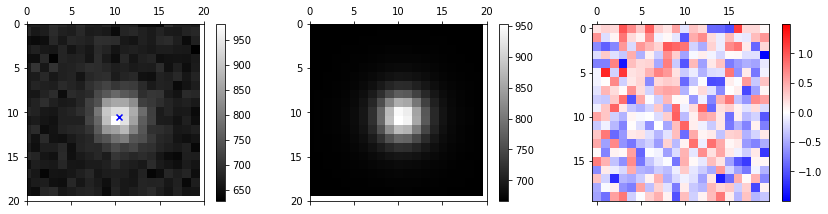

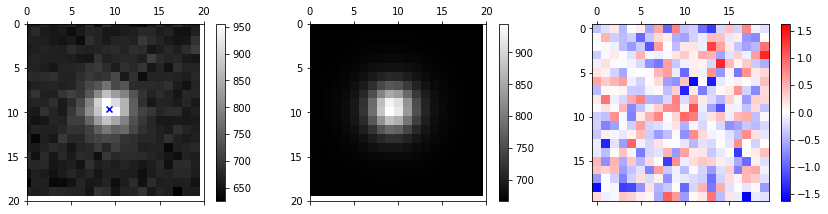

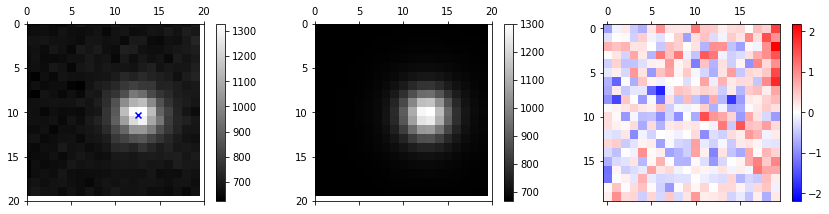

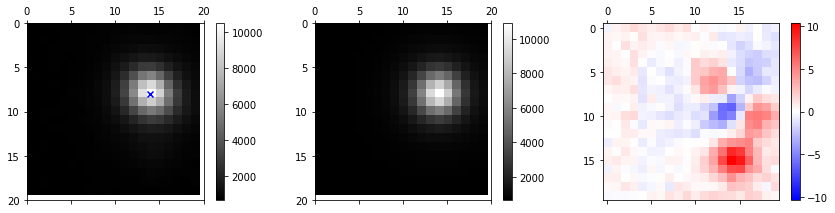

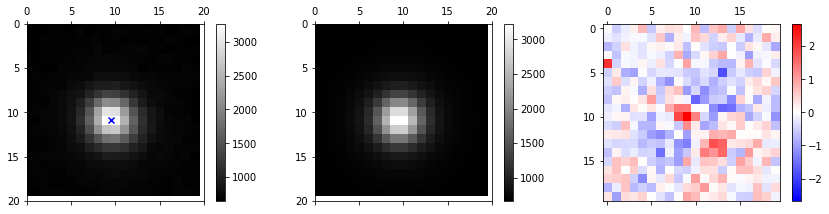

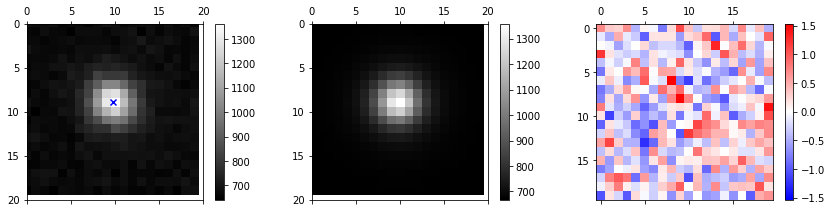

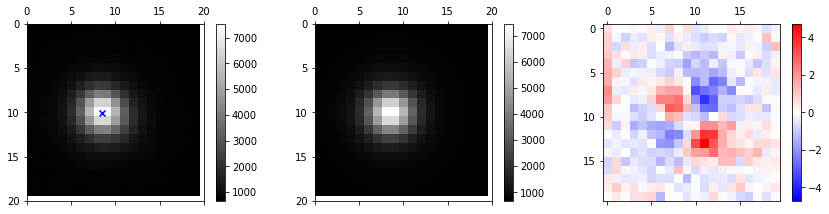

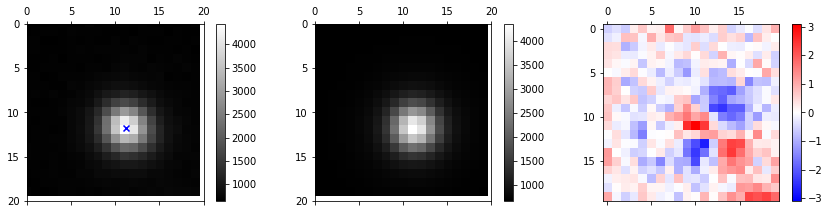

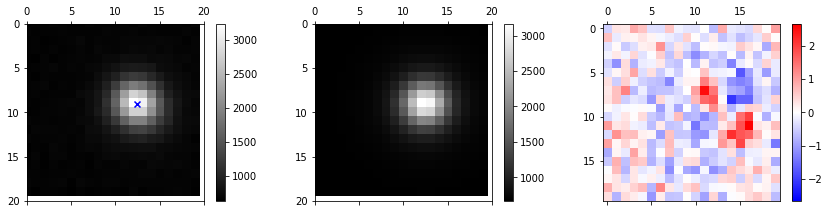

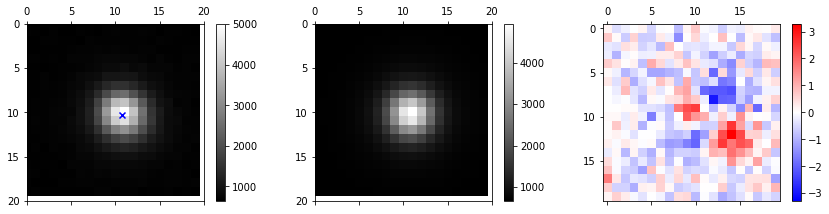

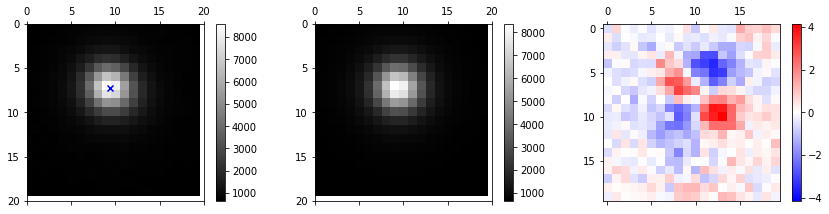

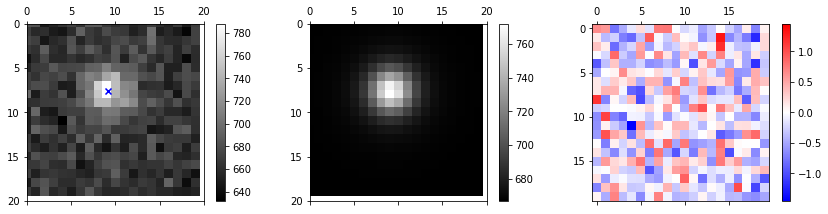

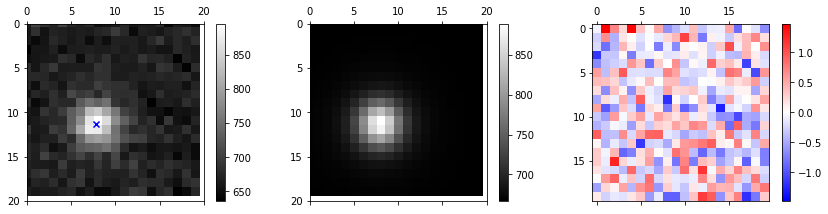

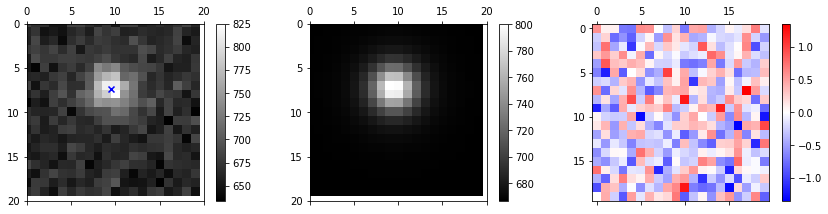

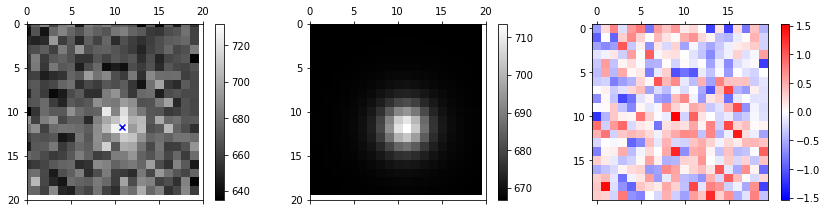

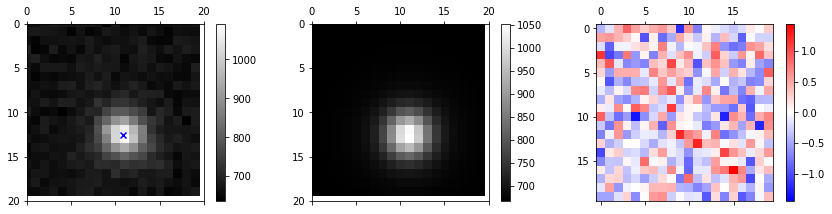

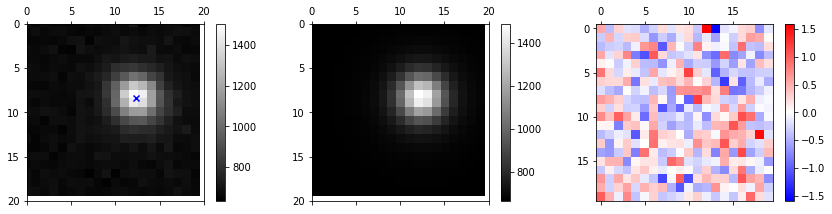

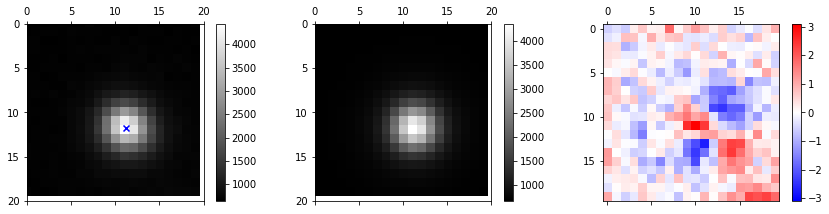

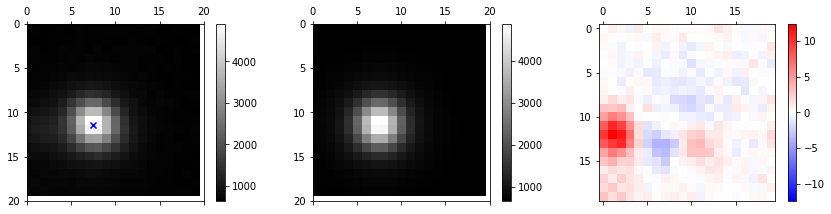

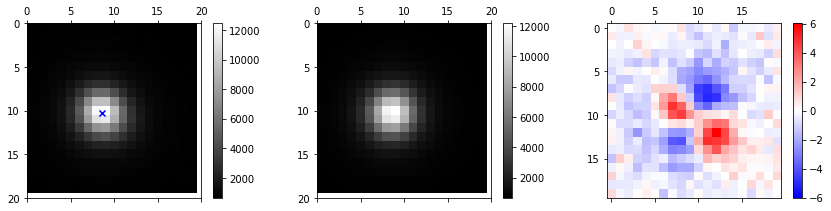

In [26]:
for i in range(psf_train_images.shape[0]): 

    f, axarr = plt.subplots(1, 3, figsize=(12, 3))
    
    im0 = plotting.plot_image(axarr[0], psf_train_images[i, 0])
    f.colorbar(im0, ax = axarr[0])
    
    
    im1 = plotting.plot_image(axarr[1], recon_mean[i, 0])
    f.colorbar(im1, ax = axarr[1])
    
    diff = (psf_train_images[i, 0] - recon_mean[i, 0]) / torch.sqrt(recon_mean[i, 0])
    vmax = torch.max(torch.abs(diff))
    im3 = axarr[2].matshow(diff, 
                           cmap = plt.get_cmap('bwr'), 
                           vmax = vmax, vmin = -vmax)
    f.colorbar(im3, ax = axarr[2])
    
    plotting.plot_locations(est_locs[i:(i+1), :] * subimage_slen,
                            axarr[0], 
                            marker = 'x')
    
    f.tight_layout()

In [27]:
np.save('./psf/testing.npy', 
        star_decoder.params.detach().numpy())

In [28]:
x0_vec = [216, 123, 51, 180, 170, 290, 270, 160, 250, 75, 40, 35, 130, 138, 255, 200, 160, 160, 20, 165]
x1_vec = [252, 297, 236, 285, 132, 140, 210, 280, 160, 37, 80, 275, 55, 248, 270, 140, 60, 280, 90, 180]

test_images = torch.zeros(len(x0_vec), 
                         image.shape[1],
                         subimage_slen, 
                         subimage_slen)

for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    test_images[i] = image[0, :, _x0:(_x0+subimage_slen), _x1:(_x1+subimage_slen)]

In [29]:
# for p in star_decoder.parameters(): 
#     print(p)
    
# print(np.load('./psf/testing.npy'))

In [30]:
config_path = '../../../config/'

In [31]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

print('config overrides: ')
print(overrides)

overrides = [f"{key}={value}" for key, value in overrides.items()]

with initialize(config_path=config_path):
    cfg = compose("config", overrides=overrides)

    

cfg.model.decoder.kwargs.update({'n_bands': 1, 
                                 'slen': 10, 
                                 'tile_slen': 10, 
                                 'ptile_slen': 30, 
                                 'border_padding': 5, 
                                 'background_values': [665.], 
                                 'max_sources': 2, 
                                 'psf_params_file': './psf/testing.npy'})

cfg.model.encoder.kwargs.update({'ptile_slen': 20})

cfg.dataset.kwargs.update({'n_batches': 10, 'batch_size': 64})

print('config: ')
print(cfg)


config overrides: 
{'model': 'sleep_m2', 'dataset': 'm2', 'training': 'm2', 'optimizer': 'm2'}
config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': '${oc.env:BLISS_HOME}', 'data': '${paths.root}/data', 'models': '${paths.root}/models', 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss'}, 'optimizer': {'name': 'Adam', 'kwargs': {'lr': 0.00098352, 'weight_decay': 8.041e-05}}, 'model': {'name': 'SleepPhase', 'kwargs': {'decoder_kwargs': '${model.decoder.kwargs}', 'encoder_kwargs': '${model.encoder.kwargs}', 'optimizer_params': '${optimizer}'}, 'decoder': {'kwargs': {'n_bands': 1, 'slen': 10, 'tile_slen': 10, 'ptile_slen': 30, 'border_padding': 5, 'max_sources': 2, 'mean_sources': 0.48, 'min_sources': 0, 'f_min': 1000.0, 'f_max': 1000000.0, 'alpha': 0.5, 'psf_params_file': './psf/testing.npy', 'prob_galaxy': 0.0, 'background_values': [665.0], 'sdss_bands': [2, 3]}}, 'encoder': {'kwargs': {'n_bands': '${model.decoder.kwargs.n_bands}', 'tile_slen': '${model.decoder.kwargs

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [32]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

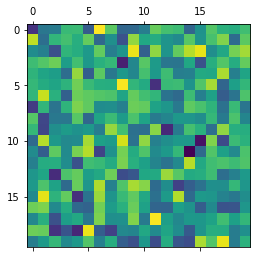

In [33]:
batch = dataset.get_batch()
tmp = batch['images']
plt.matshow(tmp[0, 0, :, :].cpu().numpy())

In [34]:
cfg.training.update({'n_epochs': 500})

In [35]:
sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [36]:
trainer.fit(sleep_net, datamodule = dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 661 K 
1 | image_decoder | ImageDecoder | 6     
-----------------------------------------------
661 K     Trainable params
6         Non-trainable params
661 K     Total params
2.646     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [37]:
sleep_net.train();

for i in range(100): 
    print(i)
    batch = dataset.get_batch()
    tmp = batch['images']
    map_est_sleep = sleep_net.image_encoder.map_estimate(tmp.cpu(),
                                                         slen = 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [38]:
sleep_net.image_encoder.eval(); 

In [39]:
map_est_sleep = sleep_net.image_encoder.map_estimate(batch['images'].cpu(),
                                                     slen = 10)

In [40]:
map_locs = map_est_sleep['locs'].squeeze().cpu().detach()
map_n_sources = map_est_sleep['n_sources'].squeeze().cpu().detach()

In [41]:
torch.mean((map_n_sources == batch['n_sources'].cpu().squeeze()).float())

tensor(0.9844)

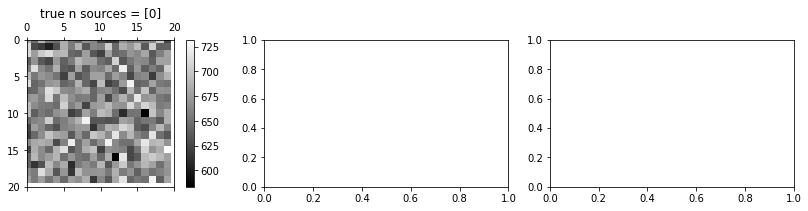

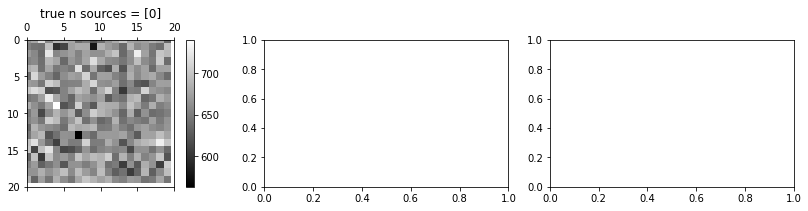

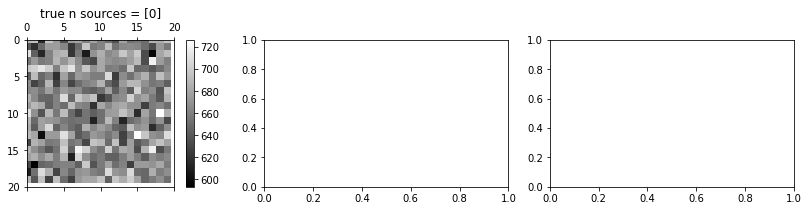

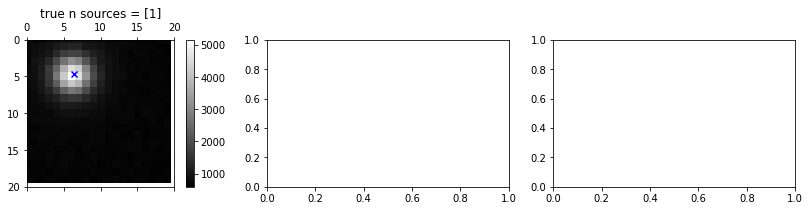

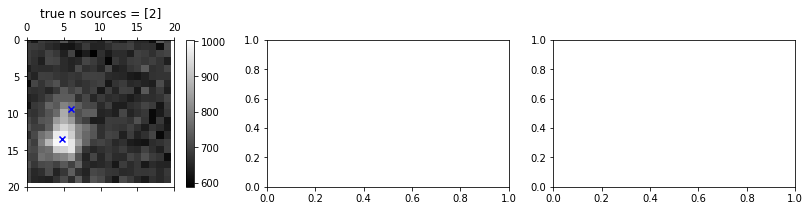

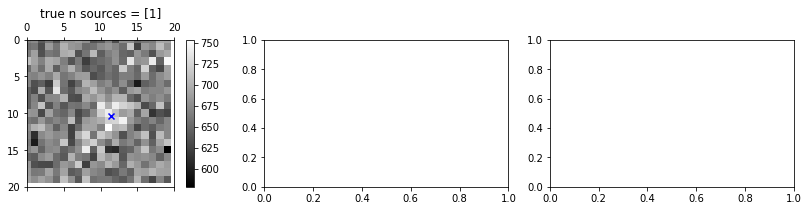

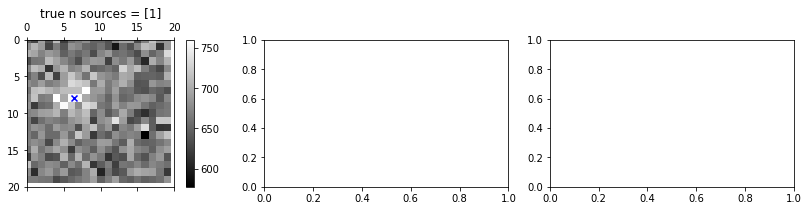

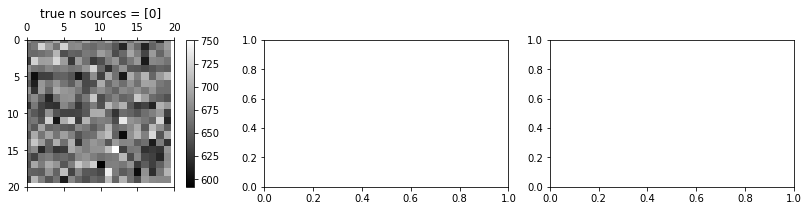

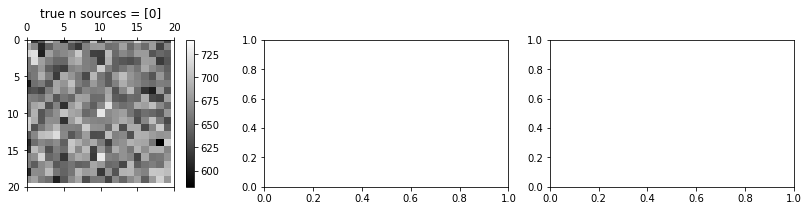

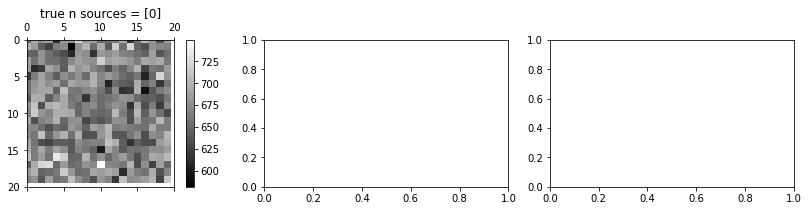

In [42]:
for indx in range(10): 
    
    i = np.random.choice(batch['images'].shape[0])

    f, axarr = plt.subplots(1, 3, figsize=(12, 3))
    
    im0 = plotting.plot_image(axarr[0], batch['images'].cpu()[i, 0])
    f.colorbar(im0, ax = axarr[0])
        
    if(map_n_sources[i] > 0):
        n = int(map_n_sources[i])
        plotting.plot_locations(map_locs[i, 0:n, :] * 10 + 5,
                                axarr[0], 
                                marker = 'x')
        
    axarr[0].set_title('true n sources = ' + 
                       str(batch['n_sources'][i].detach().cpu().numpy()))
    
    f.tight_layout()

# Try on real imagesm

In [44]:
map_est = sleep_net.image_encoder.map_estimate(test_images, slen = 10)

In [58]:
map_locs = map_est['locs'].cpu().detach()
map_n_sources = map_est['n_sources'].cpu().detach()

In [59]:
map_est['n_sources'].shape

torch.Size([20])

In [60]:
map_n_sources

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [61]:
map_locs.shape

torch.Size([20, 1, 2])

tensor([3.8028, 3.8242, 4.1258, 5.1111, 4.6618, 4.1368, 5.1200, 4.8648, 4.6234,
        4.9431, 5.2151, 3.3744, 3.6645, 3.5340, 3.0665, 3.8239, 4.1919, 4.8648,
        4.9392, 5.3328], grad_fn=<Log10Backward>)

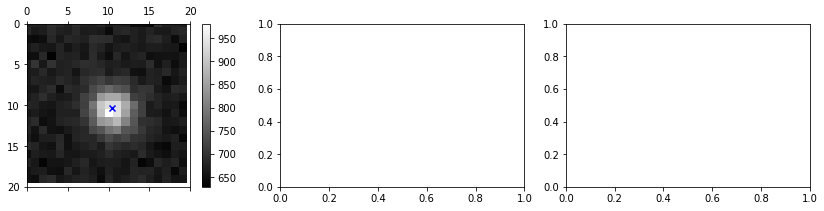

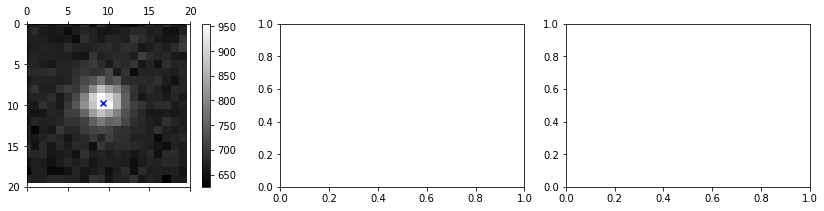

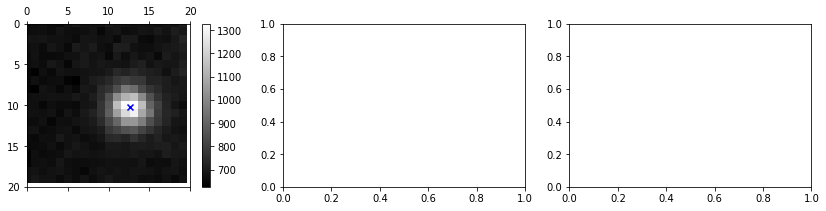

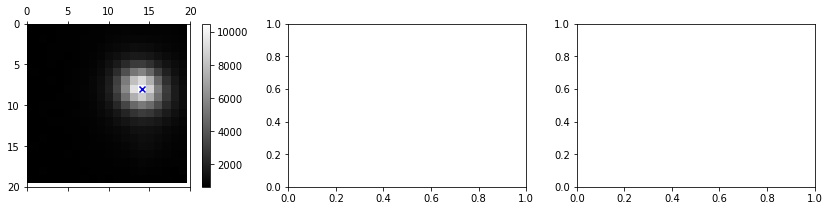

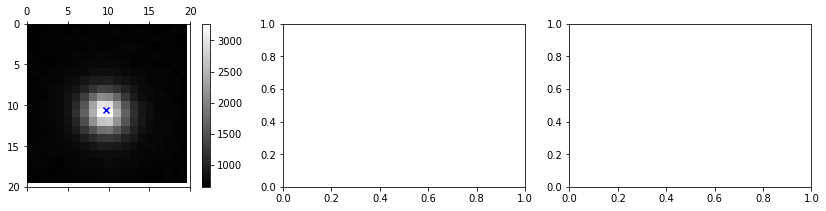

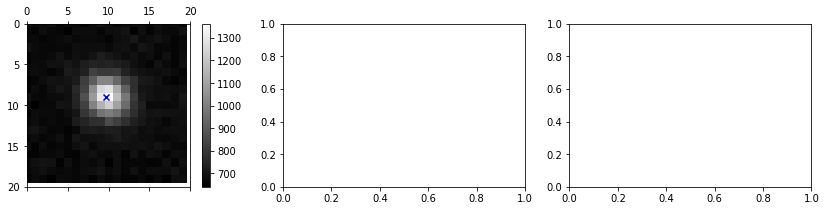

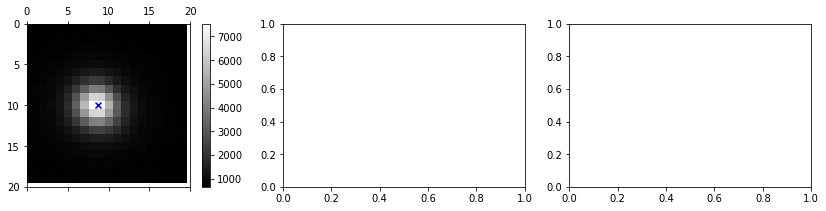

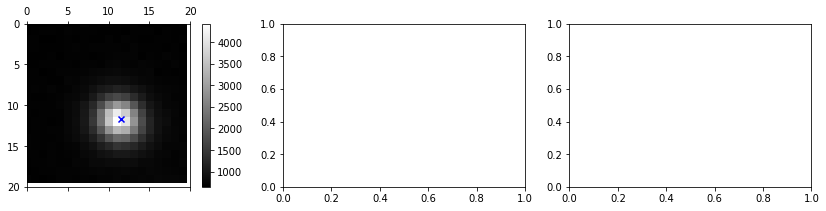

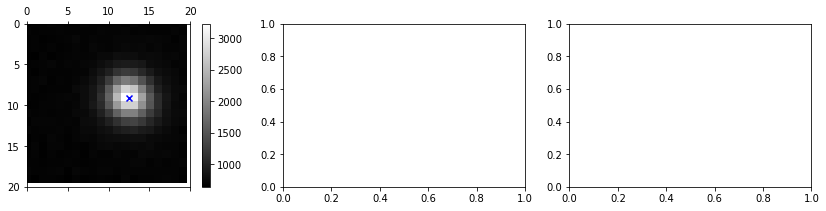

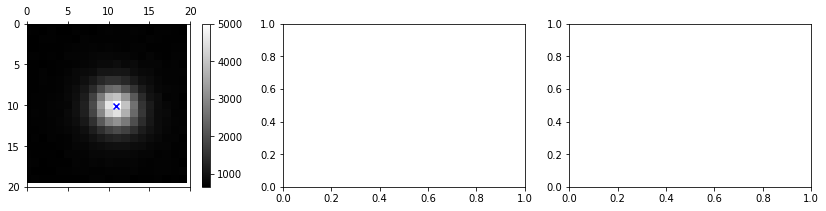

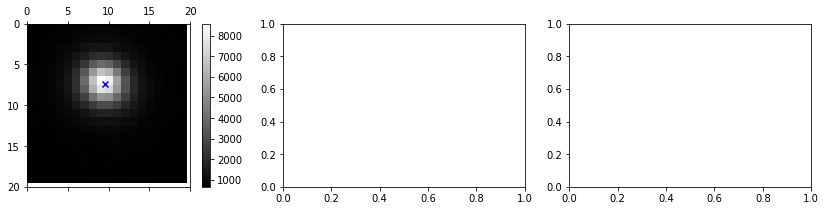

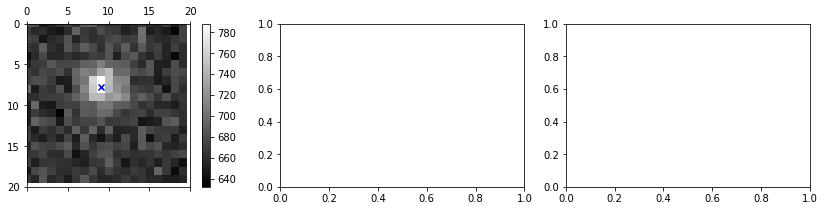

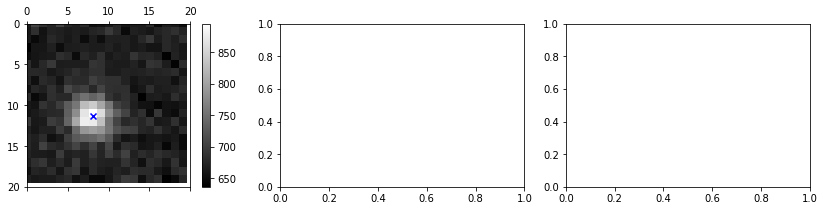

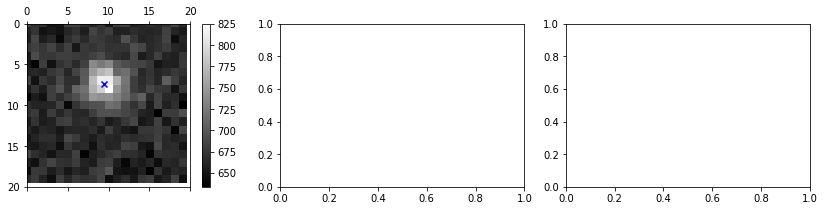

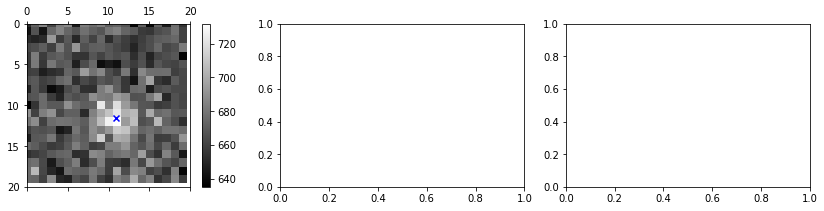

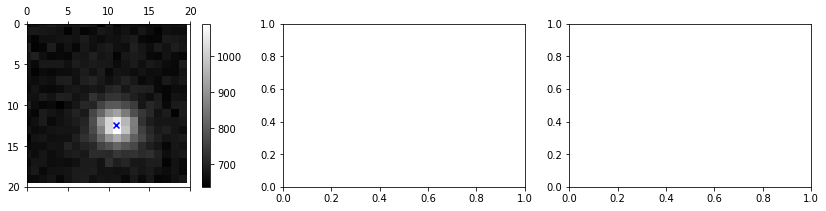

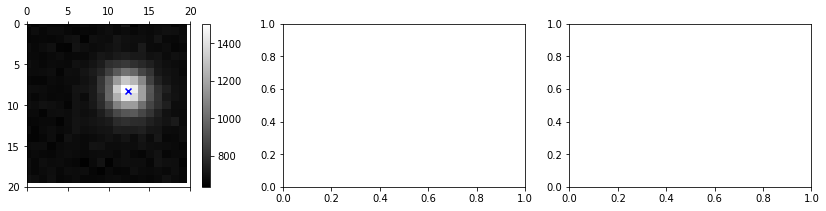

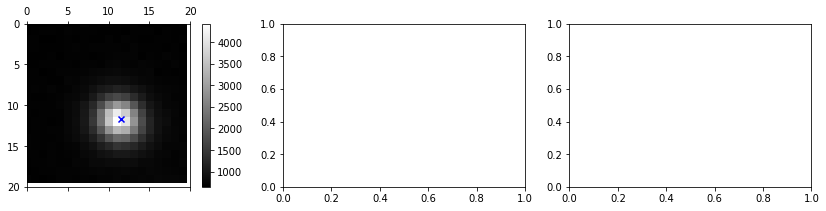

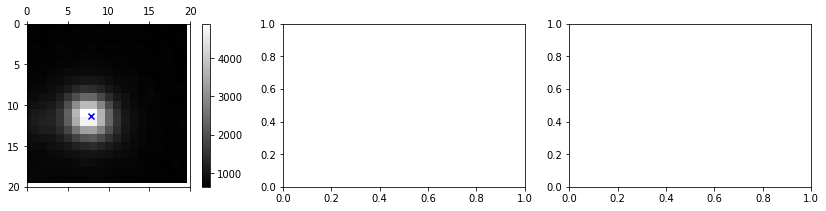

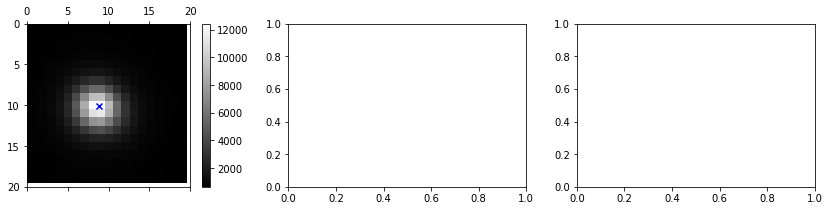

In [62]:
for i in range(test_images.shape[0]): 

    f, axarr = plt.subplots(1, 3, figsize=(12, 3))
    
    im0 = plotting.plot_image(axarr[0], test_images[i, 0])
    f.colorbar(im0, ax = axarr[0])
            
    if(map_n_sources[i] > 0):
        n = int(map_n_sources[i])
        plotting.plot_locations(map_locs[i, 0:n, :] * 10 + 5,
                                axarr[0], 
                                marker = 'x')
            
    f.tight_layout()

In [66]:
torch.log10(map_est['fluxes'].squeeze())

tensor([3.8028, 3.8242, 4.1258, 5.1111, 4.6618, 4.1368, 5.1200, 4.8648, 4.6234,
        4.9431, 5.2151, 3.3744, 3.6645, 3.5340, 3.0665, 3.8239, 4.1919, 4.8648,
        4.9392, 5.3328], grad_fn=<Log10Backward>)

In [68]:
torch.save(sleep_net.image_encoder.state_dict(), './fits/starnet_testing')